# Proyecto 1 - Autoencoders

- **Título:** Limpiando neblina de imágenes satelitales con autoencoderes convolucionales
- **Materia:**
  - **Nombre:** Aprendizaje profundo
  - **Código:** ESI2498O
- **Profesor:** Iván Reyes Amezcua
- **Fecha de entrega:** 29 de febrero de 2024
- **Alumna:**
  - **Nombre:** Judith Alejandra Hinojosa Rábago
  - **Expediente:** 737456
- **Repositorio del proyecto:** https://github.com/judith-ale/DL-Proyecto-1-Autoencoders

## Objetivos:

- Comprender los principios fundamentales de los autoencoders y su aplicación en deep learning generativo.
- Implementar un autoencoder básico y variacionales para una tarea específica, como reducción de dimensión, denoising o generación de imágenes.
- Analizar el rendimiento y las características de las representaciones aprendidas por los autoencoders.


## Descripción del proyecto

Basado en las [imágenes](https://www.dropbox.com/s/k2i3p7puuwl2g59/Haze1k.zip?e=1&dl=0) mencionadas en el artículo *Single Satellite Optical Imagery Dehazing using SAR Image Prior Based on conditional Generative Adversarial Networks* se proponen 2 arquitecturas para limpieza de neblina en imágenes satelitales, se entrenan, se ajustan y se evalúan a través de la librería `PyTorch`, donde la segunda tiene una arquitectura más compleja que la primera, por lo que se hipotetiza que este modelo tendrá un mejor desempeño.



Datos:

La imagen satelital RGB es la entrada a limpiar de neblina, mientras que la imágen objetivo es una imagen sintética, generada de la transposición de una imágen RGB en un día despejado, una imágen RGB en un día con neblina y una imágen satelital de radar de apertura sintética (SAR por sus siglas en inglés). Esta última combina la fase de la señal reflejada y la información de amplitud, es por ello que tiene una capacidad de visualización para todo tipo de clima y de día o de noche. Sin embargo no suelen tener las mismas modalidades, resoluciones, ángulos de reflexión y zonas horarias. (Huang et al., 2020)

## Obtención de imágenes y librerías

Como paso previo a la obtención de imágenes se hizo limpieza de imágenes corruptas, se eliminaron archivos que no se utilizarían y se aseguró que todas las imágenes de entrada tuvieran su respectiva imagen de salida, esto se puede ver en el notebook llamado `Limpieza de datos.ipynb`.

El archivo zip ya preparado para ser procesado por este notebook se encuentra en el siguiente [enlace](https://drive.google.com/file/d/1yDeASrtH7Vla7pJAnXhglLMGJJ6q5iki/view?usp=sharing).

En esta sección:
- Se descomprime el archivo.
- Se relocaliza la carpeta principal.
- Se obtienen las librerías para empezar a trabajar.
- Se declara el dispositivo sobre el cual se va a trabajar (GPU, de lo contrario CPU).

La distribución de los archivos es de la siguiente forma:
```
content/
├─ Haze1k/
│  ├─ Haze1k_moderate/
│  │  ├─ dataset/
│  │  │  ├─ test/ # esto para todos los directorios dentro de cada directorio llamado dataset
│  │  │  │  ├─ input/ # 45 imágenes png
│  │  │  │  ├─ target/ # 45 imágenes png
│  │  │  ├─ train/ # 318 pares de imágenes png
│  │  │  ├─ val/ # 35 pares de imágenes jpg
│  ├─ Haze1k_thick/
│  │  ├─ dataset/
│  │  │  ├─ test/ # 45 pares de imágenes png
│  │  │  ├─ train/ # 320 pares de imágenes png
│  │  │  ├─ valid/ # 35 pares de imágenes png
│  ├─ Haze1k_thin/
│  │  ├─ dataset/
│  │  │  ├─ test/ # 45 pares de imágenes png
│  │  │  ├─ train/ # 320 pares de imágenes png
│  │  │  ├─ valid/ # 35 pares de imágenes png
```

Donde cada imágen se encuentra a 3 canales (RGB) con una resolución de 512x512 pixeles.

In [ ]:
!unzip "/content/drive/MyDrive/ITESO/24P/APRENDIZAJE PROFUNDO/Haze1k.zip"

In [2]:
import shutil

# Source path
source = "/content/content/Haze1k"

# Destination path
destination = "/content"

# Move the content of source to destination
dest = shutil.move(source, destination)

In [3]:
import os
# remove "content" directory
os.rmdir("/content/content")

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

from torchvision import datasets, transforms
from torchvision.io import read_image
from torch.utils.data import Dataset

from torchsummary import summary
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Data Loaders

En esta sección:
- Se declara la clase para la obtención de pares de imágenes por cada directorio.
- Se hace una transformación de datos, donde a las imágenes se les hace un resize de 128x128, se transforma en un tensor de `PyTorch` y se dividen todos los valores entre 255 para dejar los valores entre 0 y 1.
- Se concantenan los datasets de cada categoría para cada fase del proceso `train`, `test` y `validation`.
- Se crea un dataloader para los datos concatenados y para los datos y en especial para `test` se genera un dataset por categoría para análisis posteriores.
- Se imprime un ejemplo de un par de imágenes para `train`.

### Clase para obtención del dataset

In [5]:
class CustomImageDataset(Dataset):
  def __init__(self, input_dir, target_dir, transform=None, target_transform=None):
    # Input images path
    self.input_dir = input_dir
    self.input_names = os.listdir(input_dir)
    self.input_names.sort()
    # Target images path
    self.target_dir = target_dir
    self.target_names = os.listdir(target_dir)
    self.target_names.sort()
    # Transformation method
    self.transform = transform

  def __len__(self):
    return len(self.input_names)

  def __getitem__(self, idx):
    # Get input image
    input_path = os.path.join(self.input_dir, self.input_names[idx])
    input_image = read_image(input_path)
    # Get target image
    target_path = os.path.join(self.target_dir, self.target_names[idx])
    target_image = read_image(target_path)
    # If transform function specified, transform
    if self.transform:
      input_image, target_image = self.transform(input_image, target_image)
    # Scale
    input_image = torch.div(input_image, 255)
    target_image = torch.div(target_image, 255)
    # Return pair of input and target images
    return input_image, target_image

### Proceso

#### Funciones para obtener los directorios y la transformación que se le hará a las imágenes

In [6]:
def get_img_dir(split_type='train', haze='moderate'):
  return (f"/content/Haze1k/Haze1k_{haze}/dataset/{split_type}/input",
  f"/content/Haze1k/Haze1k_{haze}/dataset/{split_type}/target")

In [7]:
def transformation(size):
  def random_crop(input, target):
    i, j, h, w = transforms.RandomCrop.get_params(
              input, output_size=(size, size))
    input = transforms.functional.crop(input, i, j, h, w)
    target = transforms.functional.crop(target, i, j, h, w)
    return input, target

  rescale = transforms.Resize(size, antialias=True)
  def resize(input, target):
    input = rescale(input)
    target = rescale(target)
    return input, target
  return resize

#### Obtención de cada directorio

Cada directorio tiene una clasificación distinta de imágenes dependiendo de la cantidad de nubosidad que tengan (`thin`, `moderate`, `thick`) y dependiendo de en qué parte del proceso se utilicen (`train`, `test`, `validation`).

In [8]:
m_in_train_dir, m_tg_train_dir = get_img_dir(split_type='train', haze='moderate')
m_in_test_dir, m_tg_test_dir = get_img_dir(split_type='test', haze='moderate')
m_in_val_dir, m_tg_val_dir = get_img_dir(split_type='val', haze='moderate')

tn_in_train_dir, tn_tg_train_dir = get_img_dir(split_type='train', haze='thin')
tn_in_test_dir, tn_tg_test_dir = get_img_dir(split_type='test', haze='thin')
tn_in_val_dir, tn_tg_val_dir = get_img_dir(split_type='valid', haze='thin')

tk_in_train_dir, tk_tg_train_dir = get_img_dir(split_type='train', haze='thick')
tk_in_test_dir, tk_tg_test_dir = get_img_dir(split_type='test', haze='thick')
tk_in_val_dir, tk_tg_val_dir = get_img_dir(split_type='valid', haze='thick')

In [9]:
size = 128 # Image size

transform = transformation(size)

In [10]:
train_moderate = CustomImageDataset(m_in_train_dir, m_tg_train_dir,
                           transform=transform)

train_thin = CustomImageDataset(tn_in_train_dir, tn_tg_train_dir,
                           transform=transform)

train_thick = CustomImageDataset(tk_in_train_dir, tk_tg_train_dir,
                           transform=transform)

In [11]:
len(train_moderate.input_names), len(train_thin.input_names), len(train_thick.input_names)

(318, 320, 320)

In [12]:
test_moderate = CustomImageDataset(m_in_test_dir, m_tg_test_dir,
                           transform=transform)

test_thin = CustomImageDataset(tn_in_test_dir, tn_tg_test_dir,
                           transform=transform)

test_thick = CustomImageDataset(tk_in_test_dir, tk_tg_test_dir,
                           transform=transform)

In [13]:
len(test_moderate.input_names), len(test_thin.input_names), len(test_thick.input_names)

(45, 45, 45)

In [14]:
val_moderate = CustomImageDataset(m_in_val_dir, m_tg_val_dir,
                           transform=transform)

val_thin = CustomImageDataset(tn_in_val_dir, tn_tg_val_dir,
                           transform=transform)

val_thick = CustomImageDataset(tk_in_val_dir, tk_tg_val_dir,
                           transform=transform)

In [15]:
len(val_moderate.input_names), len(val_thin.input_names), len(val_thick.input_names)

(35, 35, 35)

#### Unión de los datasets en `train`, `test` y `val`

In [16]:
train = torch.utils.data.ConcatDataset([train_moderate, train_thin, train_thick])
test = torch.utils.data.ConcatDataset([test_moderate, test_thin, test_thick])
val = torch.utils.data.ConcatDataset([val_moderate, val_thin, val_thick])

#### Creación del dataloader

In [54]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    train,
    batch_size=batch_size, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val,
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test,
    batch_size=10, shuffle=False
)

# Para test también por separado para evaluar el desempeño por cantidad de nubosidad
tn_test_loader = torch.utils.data.DataLoader(
    test_thin,
    batch_size=10, shuffle=False
)

m_test_loader = torch.utils.data.DataLoader(
    test_moderate,
    batch_size=10, shuffle=False
)

tk_test_loader = torch.utils.data.DataLoader(
    test_thick,
    batch_size=10, shuffle=False
)

### Ejemplo de imagen

In [18]:
input, target = train.__getitem__(900)

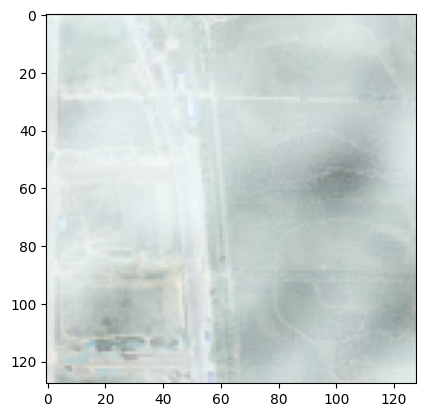

In [19]:
img = transforms.ToPILImage()(input)
img = np.array(img)
plt.imshow(img)
plt.show()

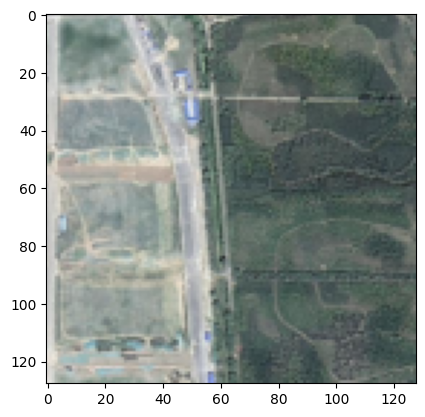

In [20]:
img = transforms.ToPILImage()(target)
img = np.array(img)
plt.imshow(img)
plt.show()

## Modelo 1

En esta sección:
- Se hace el diseño de la arquitectura del primer modelo, donde se tienen dos capas convolucionales como encoder y dos capas convolucionales transpuestas como decoder con la última función de activación siendo una sigmoidal para acotar los valores entre 0 y 1.
- Se imprime la arquitectura.
- Se declara MSE como función de costo.
- Se entrena con las el dataloader de las imágenes `train` de 10 en 10 épocas.
- De ser necesario se guardan los pesos del modelo para utilizarlos en posteriores ocasiones.

### Diseño

In [21]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()

    self.encoder =  nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=2, stride=2, padding=2),
        nn.Conv2d(16, 8, kernel_size=2, stride=2, padding=2)
    )

    self.decoder =  nn.Sequential(
        nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2, padding=2),
        nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2, padding=2),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

### Implementación

In [22]:
model = Autoencoder()
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
    (1): Conv2d(16, 8, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
    (1): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
    (2): Sigmoid()
  )
)

In [23]:
summary(model, (3, size, size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 66, 66]             208
            Conv2d-2            [-1, 8, 35, 35]             520
   ConvTranspose2d-3           [-1, 16, 66, 66]             528
   ConvTranspose2d-4          [-1, 3, 128, 128]             195
           Sigmoid-5          [-1, 3, 128, 128]               0
Total params: 1,451
Trainable params: 1,451
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 1.89
Params size (MB): 0.01
Estimated Total Size (MB): 2.08
----------------------------------------------------------------


In [24]:
criterion = nn.MSELoss() # Cost function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 10

In [26]:
model.load_state_dict(torch.load("/content/model_1", map_location=device))

<All keys matched successfully>

### Entrenamiento

In [27]:
for epoch in range(1, 1 + n_epochs):
  train_loss = .0

  for inputs, targets in train_loader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    optimizer.zero_grad() # Resets gradients to zero

    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*inputs.size(0)

  val_loss = .0

  with torch.no_grad():
    for inputs, targets in val_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      val_loss += criterion(outputs, targets).item() * inputs.size(0)

  train_loss /= len(train_loader)
  val_loss /= len(val_loader)
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      epoch,
      train_loss,
      val_loss
      ))

Epoch: 1 	Training Loss: 0.818227 	Validation Loss: 0.573925
Epoch: 2 	Training Loss: 0.706314 	Validation Loss: 0.558145
Epoch: 3 	Training Loss: 0.688319 	Validation Loss: 0.563800
Epoch: 4 	Training Loss: 0.684085 	Validation Loss: 0.584802
Epoch: 5 	Training Loss: 0.687012 	Validation Loss: 0.575488
Epoch: 6 	Training Loss: 0.682299 	Validation Loss: 0.564001
Epoch: 7 	Training Loss: 0.679520 	Validation Loss: 0.596890
Epoch: 8 	Training Loss: 0.685675 	Validation Loss: 0.584107
Epoch: 9 	Training Loss: 0.679384 	Validation Loss: 0.601324
Epoch: 10 	Training Loss: 0.687213 	Validation Loss: 0.564630


### Almacenamiento

In [28]:
# save model
torch.save(model.state_dict(), '/content/model_1')

## Modelo 2

En esta sección:
- Se hace el diseño de la arquitectura del segundo modelo, donde se busca una arquitectura más compleja para comparar la diferencia que pueda tener con el primer modelo, donde cada una de las dos capas convolucionales tiene una función de activación ReLu y un posterior max pooling como encoder y dos capas convolucionales transpuestas como decoder con la primera teniendo una función de activación ReLu y la última una función de activación sigmoidal para acotar los valores entre 0 y 1.
- Se imprime la arquitectura.
- Se declara MSE como función de costo.
- Se entrena con las el dataloader de las imágenes `train` de 10 en 10 épocas.
- De ser necesario se guardan los pesos del modelo para utilizarlos en posteriores ocasiones.

### Diseño

In [29]:
class Autoencoder_2(nn.Module):
  def __init__(self):
    super(Autoencoder_2, self).__init__()

    self.encoder =  nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(16, 4, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    self.decoder =  nn.Sequential(
        nn.ConvTranspose2d(4, 16, kernel_size=2, stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

### Implementación

In [30]:
model2 = Autoencoder_2()
model2.to(device)

Autoencoder_2(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [31]:
summary(model2, (3, size, size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4            [-1, 4, 64, 64]             580
              ReLU-5            [-1, 4, 64, 64]               0
         MaxPool2d-6            [-1, 4, 32, 32]               0
   ConvTranspose2d-7           [-1, 16, 64, 64]             272
              ReLU-8           [-1, 16, 64, 64]               0
   ConvTranspose2d-9          [-1, 3, 128, 128]             195
          Sigmoid-10          [-1, 3, 128, 128]               0
Total params: 1,495
Trainable params: 1,495
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 6.53
Params size (MB): 0.01
Estimated Total

In [32]:
criterion2 = nn.MSELoss() # Cost function
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
n_epochs = 10

In [33]:
model2.load_state_dict(torch.load("/content/model_2", map_location=device))

<All keys matched successfully>

### Entrenamiento

In [34]:
for epoch in range(1, 1 + n_epochs):
  train_loss = .0

  for inputs, targets in train_loader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    optimizer2.zero_grad() # Se inician los gradientes en cero

    outputs = model2(inputs)
    loss = criterion2(outputs, targets)
    loss.backward()
    optimizer2.step()
    train_loss += loss.item()*inputs.size(0)

  val_loss = .0
  with torch.no_grad():
    for inputs, targets in val_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model2(inputs)
      val_loss += criterion2(outputs, targets).item() * inputs.size(0)

  train_loss /= len(train_loader)
  val_loss /= len(val_loader)
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      epoch,
      train_loss,
      val_loss
      ))

Epoch: 1 	Training Loss: 0.444046 	Validation Loss: 0.382488
Epoch: 2 	Training Loss: 0.409482 	Validation Loss: 0.396468
Epoch: 3 	Training Loss: 0.410101 	Validation Loss: 0.377768
Epoch: 4 	Training Loss: 0.414225 	Validation Loss: 0.386429
Epoch: 5 	Training Loss: 0.407382 	Validation Loss: 0.379691
Epoch: 6 	Training Loss: 0.404706 	Validation Loss: 0.386340
Epoch: 7 	Training Loss: 0.405424 	Validation Loss: 0.408069
Epoch: 8 	Training Loss: 0.407346 	Validation Loss: 0.387376
Epoch: 9 	Training Loss: 0.403592 	Validation Loss: 0.384219
Epoch: 10 	Training Loss: 0.403833 	Validation Loss: 0.391726


### Almacenamiento

In [36]:
# save model
torch.save(model2.state_dict(), '/content/model_2')

## Evaluación de modelos

En esta sección:
- Se evalua la función de pérdida para ambos modelos por cada categoría.
- Se imprime una comparación de las imágenes de entrada, objetivo y salidas de los dos modelos por cada categoría.

In [38]:
df = pd.DataFrame(columns=['Model', 'Thin Haze', 'Moderate Haze', 'Thick Haze'])

In [39]:
df.loc[:, 'Model'] = ['Model 1', 'Model 2']

In [42]:
test_loss1 = .0
test_loss2 = .0

model.eval()
model2.eval()

# initialize a no-gradient context
with torch.no_grad():
  # loop over category datasets
  for loader, category in [
      (tn_test_loader, 'Thin Haze'),
       (m_test_loader, 'Moderate Haze'),
        (tk_test_loader, 'Thick Haze')]:

        # loop over the current batch of test data
        for inputs, targets in loader:
          inputs = inputs.to(device)
          targets = targets.to(device)

          outputs1 = model(inputs)
          outputs2 = model2(inputs)

          test_loss1 += criterion(outputs1, targets).item() * inputs.size(0)
          test_loss2 += criterion2(outputs2, targets).item() * inputs.size(0)

        test_loss1 /= len(loader)
        test_loss2 /= len(loader)

        df.loc[:, category] = [test_loss1, test_loss2]

<ipython-input-42-6d24a3035712>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, category] = [test_loss1, test_loss2]


In [45]:
df.set_index('Model') # Loss for each category of haze in images

Thin Haze  Moderate Haze  Thick Haze
Model                                        
Model 1   0.167973       0.152593    0.256971
Model 2   0.129664       0.106581    0.206027

En la tabla se muestra MSE como métrica de comparación.

Como era esperado, parece que el segundo modelo sí tuvo un mejor desempeño que el primer modelo.

In [66]:
def print_results(data_loader, category):
  # obtain one batch of test images
  inputs, targets = next(iter(data_loader))

  inputs = inputs.to(device)
  # get sample outputs
  outputs1 = model(inputs)
  outputs2 = model2(inputs)

  # prep images for display
  targets = targets.numpy()
  inputs = inputs.numpy()

  # outputs are resized
  outputs1 = outputs1.view(10, 3, size, size)
  outputs2 = outputs2.view(10, 3, size, size)

  # detach when requires_grad
  outputs1 = outputs1.cpu().detach().numpy()
  outputs2 = outputs2.cpu().detach().numpy()

  fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(25,10))

  fig.suptitle(category, fontsize = 50)

  # input images on top row, reconstructions on bottom
  for images, row in zip([inputs, targets, outputs1, outputs2], axes):
    for img, ax in zip(images, row):
      ax.imshow(img.T)
      ax.get_xaxis().set_visible(False)
      plt.setp(ax.get_yticklabels(), visible=False)
      ax.tick_params(axis='both', which='both', length=0)

  for i, label in zip(range(axes.shape[0]), ('Input', 'Target', 'Model 1', 'Model 2')):
    axes[i][0].set(ylabel=label)

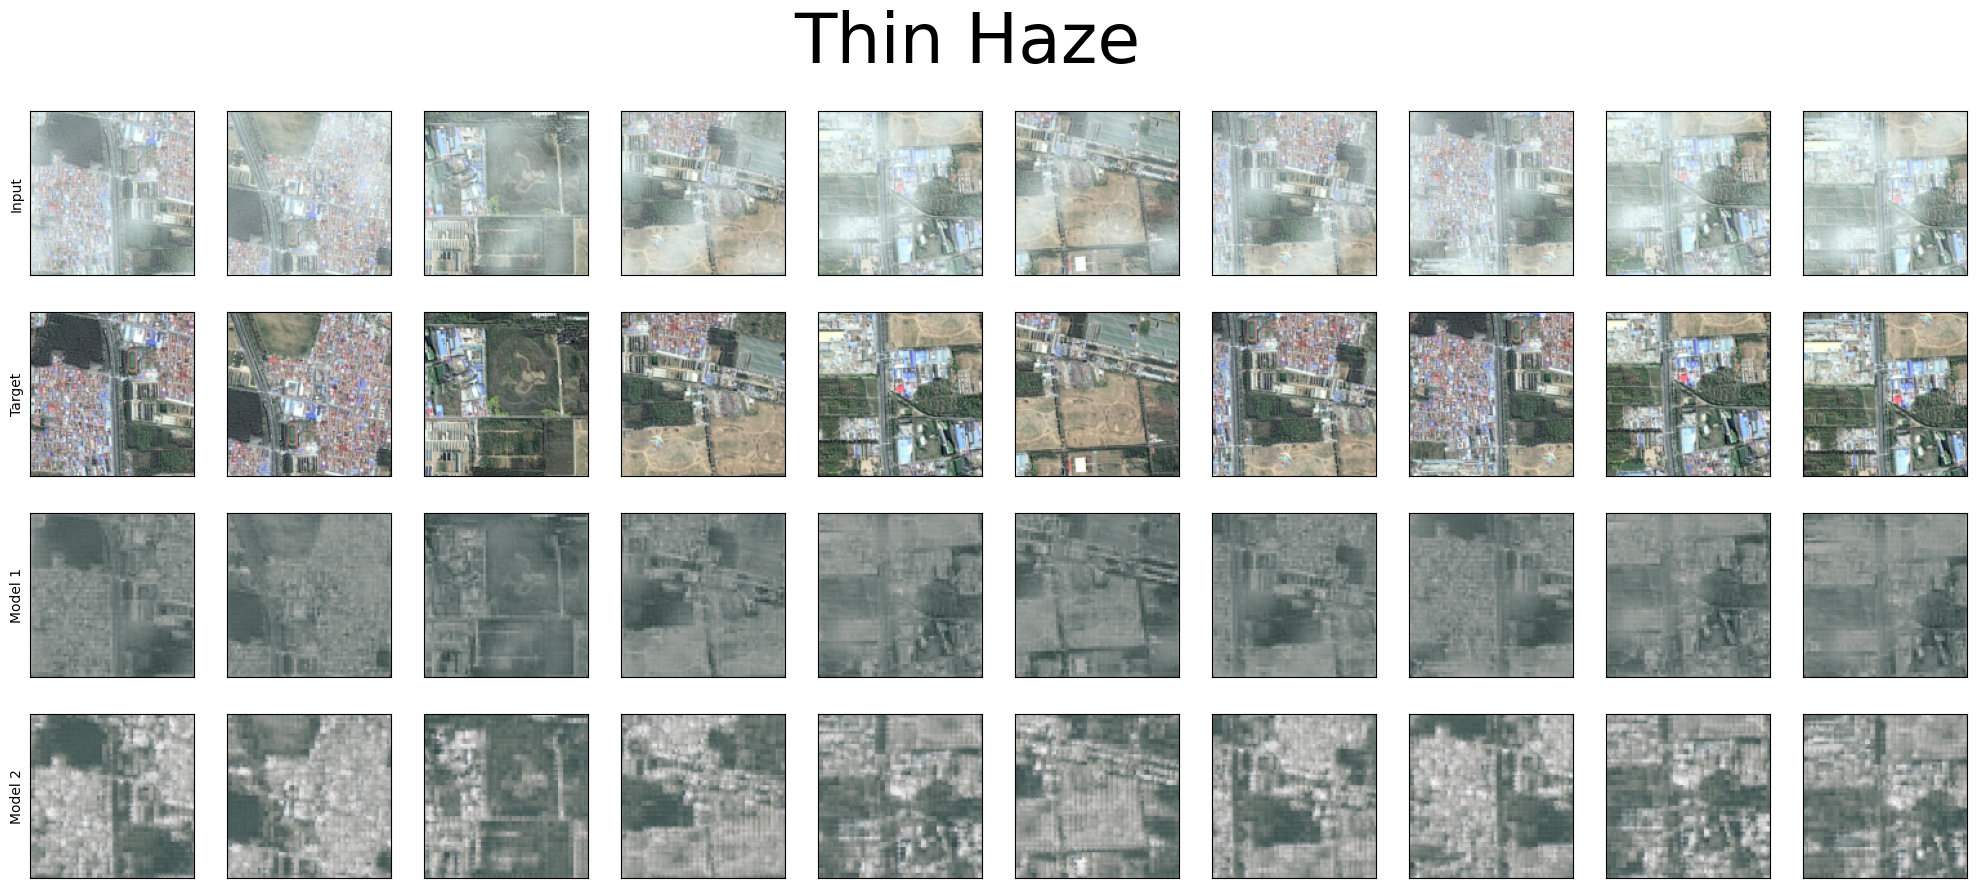

In [67]:
print_results(tn_test_loader, 'Thin Haze')

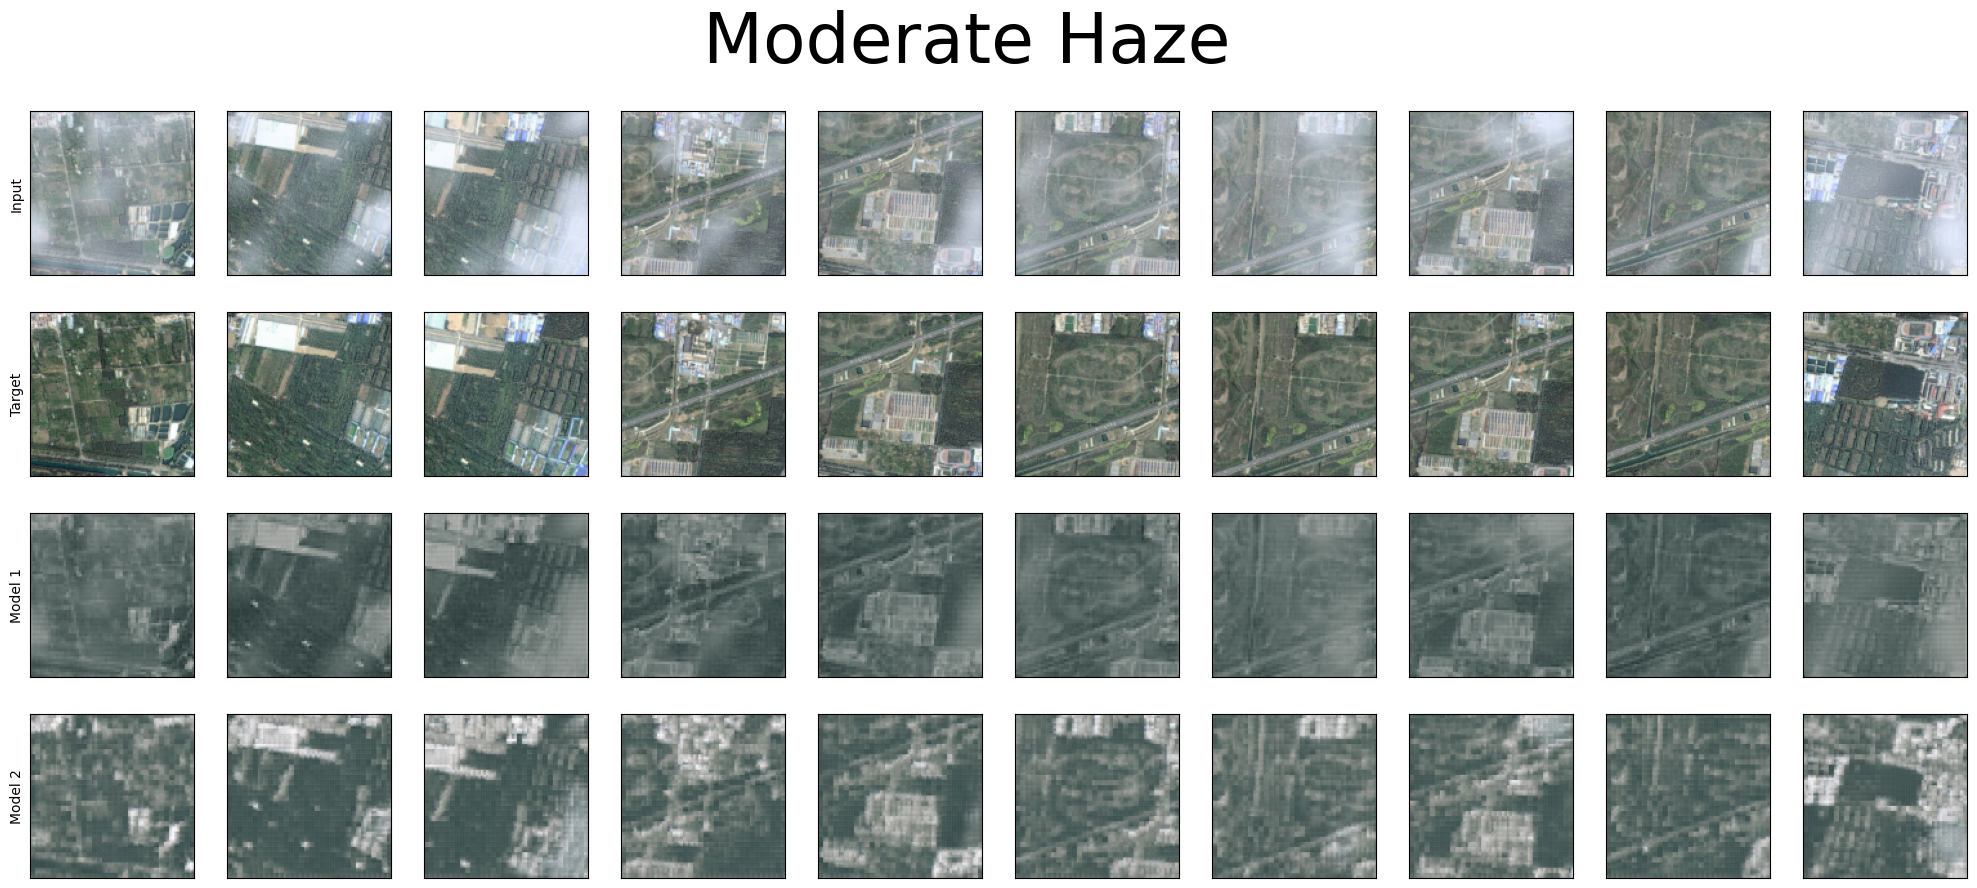

In [68]:
print_results(m_test_loader, 'Moderate Haze')

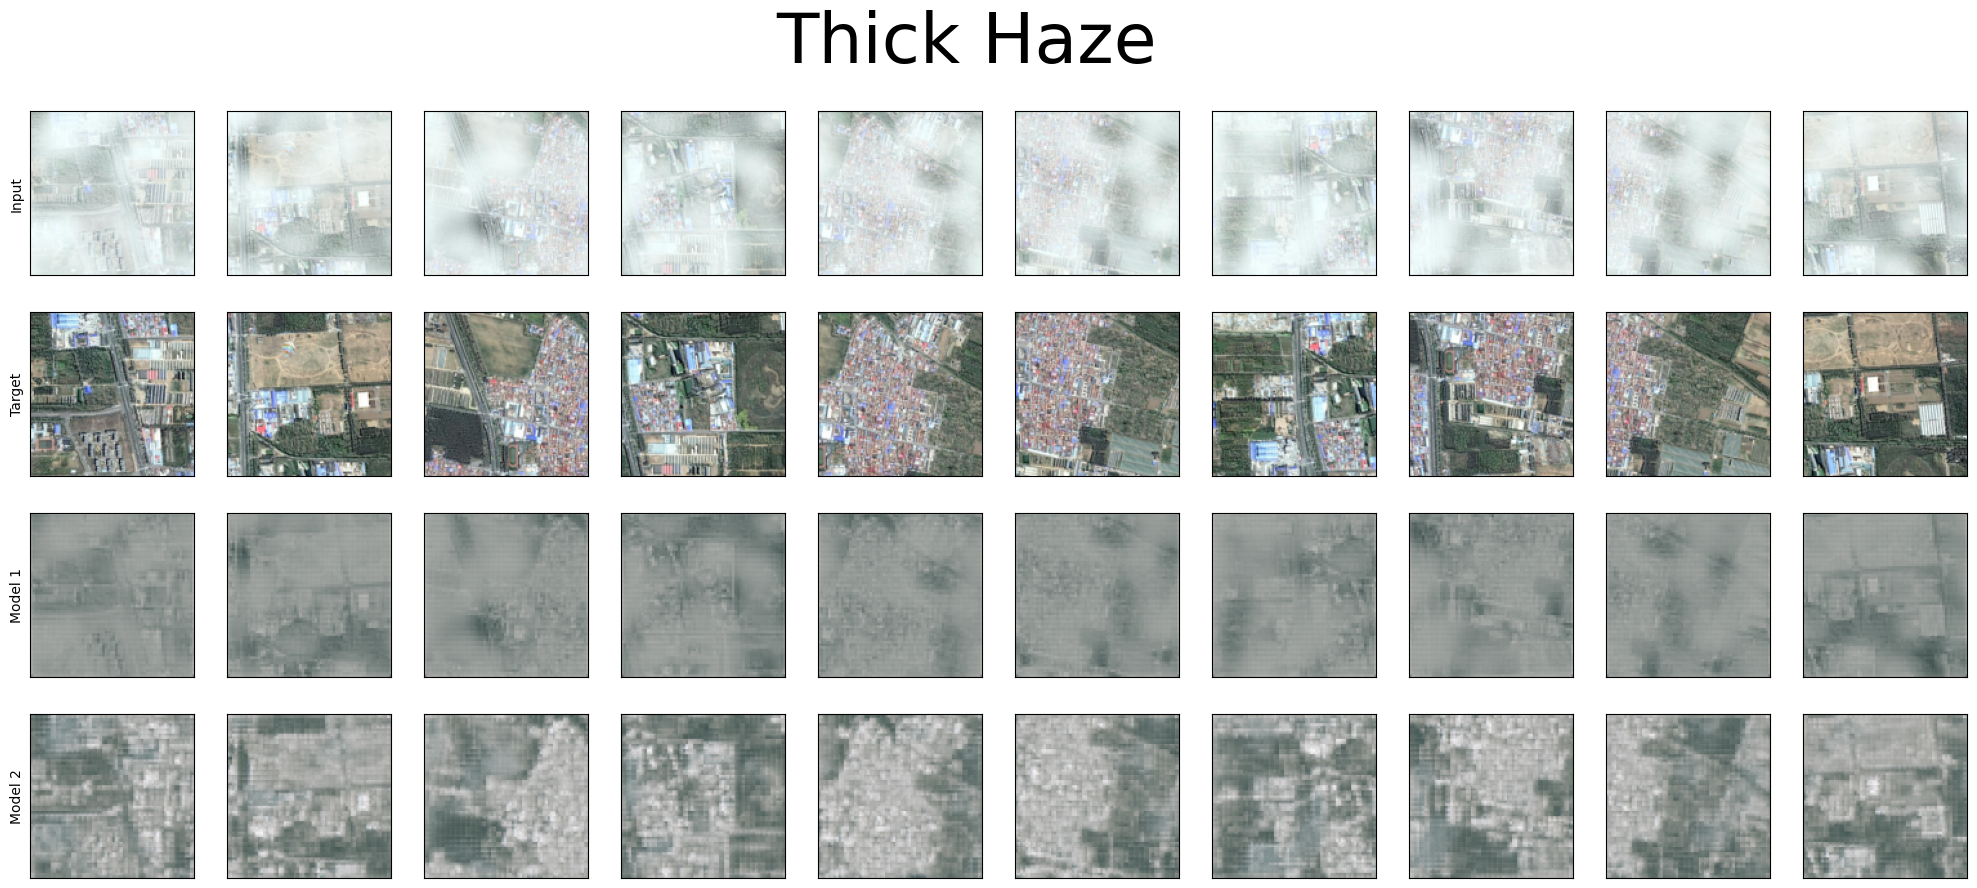

In [69]:
print_results(tk_test_loader, 'Thick Haze')

## Conclusiones

Como era lo esperado, el segundo modelo tuvo un mejor desempeño que el primero. Sin embargo, para ambos las imágenes carecen de saturación del color, esto se puede deber a la función de pérdida implementada, además del tipo de arquitectura del modelo pudiendo un *autoencoder convolucional* no ser lo más adecuado.

Potencialmente podría ser implementado en la utilización de la imágen satelital RGB en carencia de otros recursos como pueden ser imágenes SAR para análisis satelital.

## Referencias

- Huang, B., Zhi, L., Yang, C., Sun, F., & Song, Y. (2020). Single satellite optical imagery dehazing using SAR image prior based on conditional generative adversarial networks. *In Proceedings of the IEEE/CVF winter conference on applications of computer vision* (pp. 1806-1813).